<a href="https://colab.research.google.com/github/kremerlal/marchmadness24/blob/main/24MarchMadnessEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from math import *
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl

## Pivot: UPSET PREDICTOR

In [ ]:
#regular season
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/24MarchMadness/MRegularSeasonDetailedResults.csv')

# Calculate score gap for each game
df1['ScoreGap'] = df1['WScore'] - df1['LScore']

# Count number of wins for each team in each season
num_win = df1.groupby(['Season', 'WTeamID'])['DayNum'].count().reset_index().rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

# Count number of losses for each team in each season
num_loss = df1.groupby(['Season', 'LTeamID'])['DayNum'].count().reset_index().rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

# Calculate average score gap for each team's wins in each season
gap_win = df1.groupby(['Season', 'WTeamID'])['ScoreGap'].mean().reset_index().rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

# Calculate average score gap for each team's losses in each season
gap_loss = df1.groupby(['Season', 'LTeamID'])['ScoreGap'].mean().reset_index().rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

# Combine all dataframes into a single dataframe
df_reg = pd.concat([num_win, num_loss], axis=0, sort=False).groupby(['Season', 'TeamID']).sum().reset_index()
df_reg = df_reg.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_reg = df_reg.merge(gap_loss, on=['Season', 'TeamID'], how='left')

# Fill missing values with 0
df_reg.fillna(0, inplace=True)

# Calculate win ratio and average score gap for each team in each season
df_reg['WinRatio'] = df_reg['NumWins'] / (df_reg['NumWins'] + df_reg['NumLosses'])
df_reg['GapAvg'] = (df_reg['NumWins'] * df_reg['GapWins'] - df_reg['NumLosses'] * df_reg['GapLosses']) / (df_reg['NumWins'] + df_reg['NumLosses'])


In [ ]:
# Count number of away wins for each team in each season
away_win = df1[df1['WLoc'].isin(['A', 'N'])].groupby(['Season', 'WTeamID']).size().reset_index(name='AwayWins').rename(columns={"WTeamID": "TeamID"})

# Count number of neutral wins for each team in each season
nu_win = df1[df1['WLoc'].isin(['N'])].groupby(['Season', 'WTeamID']).size().reset_index(name='NeutralWins').rename(columns={"WTeamID": "TeamID"})

In [ ]:
df_reg.columns

Index(['Season', 'TeamID', 'NumWins', 'NumLosses', 'GapWins', 'GapLosses',
       'WinRatio', 'GapAvg'],
      dtype='object')

In [ ]:
#combine with regular season df
df_reg = df_reg.merge(away_win, on=['Season', 'TeamID'], how='left')
df_reg = df_reg.merge(nu_win, on=['Season', 'TeamID'], how='left')
df_reg['AwayWinRatio'] = df_reg['AwayWins'] / (df_reg['NumWins'])
df_reg['NeutralWinRatio'] = df_reg['NeutralWins'] / (df_reg['NumWins'])

In [ ]:
# Calculate 3 point % in games and lost
df1['W3ptPer'] = df1['WFGM3'] / df1['WFGA']
df1['L3ptPer'] = df1['LFGM3'] / df1['LFGA']

# Calculate average 3 pt % games won
W3pt = df1.groupby(['Season', 'WTeamID'])['W3ptPer'].mean().reset_index().rename(columns={"W3ptPer": "3ptPer", "WTeamID": "TeamID"})

# Calculate average 3 pt % games lost
L3pt = df1.groupby(['Season', 'LTeamID'])['L3ptPer'].mean().reset_index().rename(columns={"L3ptPer": "3ptPer", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
threept = pd.concat([W3pt, L3pt], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()


In [ ]:
# Calculate 2 point % in games and lost
df1['W2ptPer'] = (df1['WFGM'] - df1['WFGM3']) / df1['WFGA']
df1['L2ptPer'] = (df1['LFGM'] - df1['LFGM3']) / df1['LFGA']

# Calculate average 2 pt % games won
W2pt = df1.groupby(['Season', 'WTeamID'])['W2ptPer'].mean().reset_index().rename(columns={"W2ptPer": "2ptPer", "WTeamID": "TeamID"})

# Calculate average 2 pt % games lost
L2pt = df1.groupby(['Season', 'LTeamID'])['L2ptPer'].mean().reset_index().rename(columns={"L2ptPer": "2ptPer", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
twopt = pd.concat([W2pt, L2pt], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
# Calculate Field Goal % in games and lost
df1['WFGPer'] = df1['WFGM'] / df1['WFGA']
df1['LFGPer'] = df1['LFGM'] / df1['LFGA']

# Calculate average 2 pt % games won
WFG = df1.groupby(['Season', 'WTeamID'])['WFGPer'].mean().reset_index().rename(columns={"WFGPer": "FGPer", "WTeamID": "TeamID"})

# Calculate average 2 pt % games lost
LFG = df1.groupby(['Season', 'LTeamID'])['LFGPer'].mean().reset_index().rename(columns={"LFGPer": "FGPer", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
FG = pd.concat([WFG, LFG], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
# Calculate Free Throw % in games and lost
df1['WFTPer'] = df1['WFTM'] / df1['WFTA']
df1['LFTPer'] = df1['LFTM'] / df1['LFTA']

# Calculate average Free Throw % games won
WFT = df1.groupby(['Season', 'WTeamID'])['WFTPer'].mean().reset_index().rename(columns={"WFTPer": "FTPer", "WTeamID": "TeamID"})

# Calculate average Free Throw % games lost
LFT = df1.groupby(['Season', 'LTeamID'])['LFTPer'].mean().reset_index().rename(columns={"LFTPer": "FTPer", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
FT = pd.concat([WFT, LFT], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
#Average offensive rebounds games won
# Calculate average Offensive Rebounds games won
WOR = df1.groupby(['Season', 'WTeamID'])['WOR'].mean().reset_index().rename(columns={"WOR": "AvgOR", "WTeamID": "TeamID"})

# Calculate average Offensive Rebounds games lost
LOR = df1.groupby(['Season', 'LTeamID'])['LOR'].mean().reset_index().rename(columns={"LOR": "AvgOR", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
OR = pd.concat([WOR, LOR], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
#Average Defensive rebound percentage versus the other team
# Calculate average Defensive Rebounds games won
df1['WDRPer'] = df1['WDR'] / (df1['WDR']+df1['LOR'])
df1['LDRPer'] = df1['LDR'] / (df1['LDR']+df1['WOR'])

WDRPer = df1.groupby(['Season', 'WTeamID'])['WDRPer'].mean().reset_index().rename(columns={"WDRPer": "AvgDRPer", "WTeamID": "TeamID"})

# Calculate average Defensive Rebounds games lost
LDRPer = df1.groupby(['Season', 'LTeamID'])['LDRPer'].mean().reset_index().rename(columns={"LDRPer": "AvgDRPer", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
DRPer = pd.concat([WDRPer, LDRPer], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
#Average defensive rebound percentage
# Calculate average Defensive Rebounds games won
WDR = df1.groupby(['Season', 'WTeamID'])['WDR'].mean().reset_index().rename(columns={"WDR": "AvgDR", "WTeamID": "TeamID"})

# Calculate average Defensive Rebounds games lost
LDR = df1.groupby(['Season', 'LTeamID'])['LDR'].mean().reset_index().rename(columns={"LDR": "AvgDR", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
DR = pd.concat([WDR, LDR], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
#Average steals
# Calculate average steals games won
WStl = df1.groupby(['Season', 'WTeamID'])['WStl'].mean().reset_index().rename(columns={"WStl": "AvgStl", "WTeamID": "TeamID"})

# Calculate average steals games lost
LStl = df1.groupby(['Season', 'LTeamID'])['LStl'].mean().reset_index().rename(columns={"LStl": "AvgStl", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
Stl = pd.concat([WStl, LStl], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
#Average blocks
# Calculate average blocks games won
WBlk = df1.groupby(['Season', 'WTeamID'])['WBlk'].mean().reset_index().rename(columns={"WBlk": "AvgBlk", "WTeamID": "TeamID"})

# Calculate average blocks games lost
LBlk = df1.groupby(['Season', 'LTeamID'])['LBlk'].mean().reset_index().rename(columns={"LBlk": "AvgBlk", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
Blk = pd.concat([WBlk, LBlk], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
#Average personal fouls
# Calculate fouls games won
WPF = df1.groupby(['Season', 'WTeamID'])['WPF'].mean().reset_index().rename(columns={"WPF": "AvgPF", "WTeamID": "TeamID"})

# Calculate fouls games lost
LPF = df1.groupby(['Season', 'LTeamID'])['LPF'].mean().reset_index().rename(columns={"LPF": "AvgPF", "LTeamID": "TeamID"})

# Combine dataframes into a single dataframe
PF = pd.concat([WPF, LPF], axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
dfs = [threept, twopt, FT, OR, DR, Stl, Blk, PF, FG, DRPer ]
df_stats = pd.concat(dfs, axis=0, sort=False).groupby(['Season', 'TeamID']).mean().reset_index()

In [ ]:
df_reg = df_reg.merge(df_stats, on=['Season', 'TeamID'])

In [ ]:
df_reg

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,WinRatio,GapAvg,AwayWins,NeutralWins,...,3ptPer,2ptPer,FTPer,AvgOR,AvgDR,AvgStl,AvgBlk,AvgPF,FGPer,AvgDRPer
0,2003,1102,12.0,16.0,15.583333,11.250000,0.428571,0.250000,3.0,NaN,...,0.203009,0.293363,0.641063,4.135417,17.135417,6.135417,1.916667,18.416667,0.496372,0.631152
1,2003,1103,13.0,14.0,9.384615,7.500000,0.481481,0.629630,4.0,NaN,...,0.098596,0.390672,0.734818,9.763736,19.980769,7.260989,2.315934,19.873626,0.489268,0.626752
2,2003,1104,17.0,11.0,13.176471,9.454545,0.607143,4.285714,4.0,3.0,...,0.109187,0.303749,0.704018,13.582888,23.251337,6.435829,3.679144,18.462567,0.412936,0.682424
3,2003,1105,7.0,19.0,13.000000,11.473684,0.269231,-4.884615,2.0,NaN,...,0.131845,0.269821,0.720393,13.838346,23.981203,9.932331,2.052632,19.977444,0.401666,0.649696
4,2003,1106,13.0,15.0,10.384615,9.266667,0.464286,-0.142857,5.0,NaN,...,0.112298,0.315648,0.621023,12.317949,24.133333,8.425641,3.184615,18.192308,0.427946,0.681657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,2024,1474,12.0,19.0,8.666667,14.052632,0.387097,-5.258065,3.0,1.0,...,0.137896,0.298115,0.715889,8.480263,23.934211,6.695175,2.747807,17.506579,0.436011,0.726147
7613,2024,1475,5.0,24.0,8.000000,11.375000,0.172414,-8.034483,3.0,NaN,...,0.137531,0.296713,0.752429,7.975000,24.679167,5.845833,2.300000,20.820833,0.434243,0.774864
7614,2024,1476,3.0,27.0,10.666667,16.740741,0.100000,-14.000000,NaN,NaN,...,0.154162,0.284094,0.670147,6.185185,24.666667,5.407407,2.648148,15.111111,0.438255,0.696637
7615,2024,1477,10.0,20.0,6.800000,17.400000,0.333333,-9.333333,5.0,1.0,...,0.141306,0.263605,0.703995,7.525000,21.025000,7.400000,4.725000,17.575000,0.404911,0.692943


In [ ]:
#tournament winner
df_conf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/24MarchMadness/MConferenceTourneyGames.csv')

In [ ]:
df_conf_pivot = df_conf.groupby(['Season', 'ConfAbbrev']).max(['DayNum'])


In [ ]:
df_conf_pivot.drop(columns='LTeamID', inplace=True)

In [ ]:
df_conf_pivot['Conf_Tournament']=1

In [ ]:
df_conf_pivot.reset_index(names=['Season', 'ConfAbbrev'], inplace=True)

In [ ]:
df_conf_pivot.drop(columns=['ConfAbbrev','DayNum'], inplace=True)

In [ ]:
df_conf_pivot.rename({'WTeamID': 'TeamID'}, axis=1, inplace=True)

In [ ]:
#combine for full season
df_full = df_reg.merge(df_conf_pivot, on=['Season', 'TeamID'], how='left')

In [ ]:
df_full.fillna(0, inplace=True)

In [ ]:
#take out 2024 stats for now
df_train = df_full[df_full['Season']!=2024]

In [ ]:
df_train

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses,WinRatio,GapAvg,AwayWins,NeutralWins,...,2ptPer,FTPer,AvgOR,AvgDR,AvgStl,AvgBlk,AvgPF,FGPer,AvgDRPer,Conf_Tournament
0,2003,1102,12.0,16.0,15.583333,11.250000,0.428571,0.250000,3.0,0.0,...,0.293363,0.641063,4.135417,17.135417,6.135417,1.916667,18.416667,0.496372,0.631152,0.0
1,2003,1103,13.0,14.0,9.384615,7.500000,0.481481,0.629630,4.0,0.0,...,0.390672,0.734818,9.763736,19.980769,7.260989,2.315934,19.873626,0.489268,0.626752,0.0
2,2003,1104,17.0,11.0,13.176471,9.454545,0.607143,4.285714,4.0,3.0,...,0.303749,0.704018,13.582888,23.251337,6.435829,3.679144,18.462567,0.412936,0.682424,0.0
3,2003,1105,7.0,19.0,13.000000,11.473684,0.269231,-4.884615,2.0,0.0,...,0.269821,0.720393,13.838346,23.981203,9.932331,2.052632,19.977444,0.401666,0.649696,0.0
4,2003,1106,13.0,15.0,10.384615,9.266667,0.464286,-0.142857,5.0,0.0,...,0.315648,0.621023,12.317949,24.133333,8.425641,3.184615,18.192308,0.427946,0.681657,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,2023,1473,8.0,21.0,8.000000,14.714286,0.275862,-8.448276,2.0,0.0,...,0.305723,0.743420,6.880952,23.973214,6.005952,3.479167,16.750000,0.447311,0.705687,0.0
7251,2023,1474,15.0,15.0,7.266667,7.066667,0.500000,0.100000,10.0,3.0,...,0.283084,0.718531,9.266667,24.333333,5.933333,2.266667,16.133333,0.435535,0.761661,1.0
7252,2023,1475,13.0,16.0,9.615385,9.500000,0.448276,-0.931034,6.0,1.0,...,0.273706,0.672948,10.435096,25.002404,6.673077,2.286058,18.442308,0.430844,0.768874,0.0
7253,2023,1476,13.0,17.0,6.692308,12.647059,0.433333,-4.266667,7.0,1.0,...,0.294071,0.742237,5.006787,22.805430,6.943439,2.871041,15.027149,0.438491,0.705971,0.0


In [ ]:
# March Madness Results

In [ ]:
df_tourney = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/24MarchMadness/MNCAATourneyCompactResults.csv')

In [ ]:
df_tourney = df_tourney[df_tourney['Season'] >= 2003].reset_index(drop=True)

In [ ]:
df_seeds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/24MarchMadness/MNCAATourneySeeds.csv')

In [ ]:
df_seeds = df_seeds[df_seeds['Season'] >= 2003].reset_index(drop=True)

In [ ]:
import re
# Merge the tournament results DataFrame with the seeds DataFrame for the winning team
df = pd.merge(df_tourney, df_seeds[['Season', 'TeamID', 'Seed']], how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

# Merge the tournament results DataFrame with the seeds DataFrame for the losing team
df = pd.merge(df, df_seeds[['Season', 'TeamID', 'Seed']], how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

# Function to extract the numerical seed value from the seed column
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

# Apply the treat_seed function to the SeedW and SeedL columns
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [ ]:
df['Upset'] = np.where(df['SeedW'] > df['SeedL'], 1, 0)

In [ ]:
df.drop(columns=['WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True)

In [ ]:
df

,Season,DayNum,WTeamID,LTeamID,SeedW,SeedL,Upset
0,2003,134,1421,1411,16,16,0
1,2003,136,1112,1436,1,16,0
2,2003,136,1113,1272,10,7,1
3,2003,136,1141,1166,11,6,1
4,2003,136,1143,1301,8,9,0
...,...,...,...,...,...,...,...
1310,2023,146,1274,1400,5,2,1
1311,2023,146,1361,1166,5,6,0
1312,2023,152,1163,1274,4,5,0
1313,2023,152,1361,1194,5,9,0


In [ ]:
df.rename(columns={'WTeamID':'HighSeedTeamID', 'LTeamID':'LowSeedTeamID', 'SeedW':'SeedH'}, inplace=True)

In [ ]:
#switch IDs if the high seed lost
df['HighSeedTeamID'], df['LowSeedTeamID'] = df['LowSeedTeamID'].where(df['Upset']==1, df['HighSeedTeamID']), df['HighSeedTeamID'].where(df['Upset']==1, df['LowSeedTeamID'])

In [ ]:
df['SeedH'], df['SeedL'] = df['SeedL'].where(df['Upset']==1, df['SeedH']), df['SeedH'].where(df['Upset']==1, df['SeedL'])

In [ ]:
df

,Season,DayNum,HighSeedTeamID,LowSeedTeamID,SeedH,SeedL,Upset
0,2003,134,1421,1411,16,16,0
1,2003,136,1112,1436,1,16,0
2,2003,136,1272,1113,7,10,1
3,2003,136,1166,1141,6,11,1
4,2003,136,1143,1301,8,9,0
...,...,...,...,...,...,...,...
1310,2023,146,1400,1274,2,5,1
1311,2023,146,1361,1166,5,6,0
1312,2023,152,1163,1274,4,5,0
1313,2023,152,1361,1194,5,9,0


In [ ]:
def round_value(x, season):
    if season == 2021:
        if x == 154:
            return 6
        elif x == 152:
            return 5
        elif x in (148, 147):
            return 4
        elif x in (146, 145):
            return 3
        elif x in (140, 139):
            return 2
        elif x in (137, 138):
            return 1
        else:
            return 0
    else:
        if x == 154:
            return 6
        elif x == 152:
            return 5
        elif x in (145, 146):
            return 4
        elif x in (143, 144):
            return 3
        elif x in (138, 139):
            return 2
        elif x in (136, 137):
            return 1
        else:
            return 0

In [ ]:
df['Round'] = df.apply(lambda row: round_value(row['DayNum'], row['Season']), axis=1)

In [ ]:
#attach winning teams regular szn stats
df_stats = df.merge(df_train, left_on=['Season', 'HighSeedTeamID'], right_on=['Season', 'TeamID'])

In [ ]:
df_stats.drop(columns=['TeamID'], inplace=True)

In [ ]:
#attach losing teams regular szn stats
df_stats = df_stats.merge(df_train, left_on=['Season', 'LowSeedTeamID'], right_on=['Season', 'TeamID'], suffixes=('_HighSeed', '_LowSeed'))

In [ ]:
df_stats.columns

Index(['Season', 'DayNum', 'HighSeedTeamID', 'LowSeedTeamID', 'SeedH', 'SeedL',
       'Upset', 'Round', 'NumWins_HighSeed', 'NumLosses_HighSeed',
       'GapWins_HighSeed', 'GapLosses_HighSeed', 'WinRatio_HighSeed',
       'GapAvg_HighSeed', 'AwayWins_HighSeed', 'NeutralWins_HighSeed',
       'AwayWinRatio_HighSeed', 'NeutralWinRatio_HighSeed', '3ptPer_HighSeed',
       '2ptPer_HighSeed', 'FTPer_HighSeed', 'AvgOR_HighSeed', 'AvgDR_HighSeed',
       'AvgStl_HighSeed', 'AvgBlk_HighSeed', 'AvgPF_HighSeed',
       'FGPer_HighSeed', 'AvgDRPer_HighSeed', 'Conf_Tournament_HighSeed',
       'TeamID', 'NumWins_LowSeed', 'NumLosses_LowSeed', 'GapWins_LowSeed',
       'GapLosses_LowSeed', 'WinRatio_LowSeed', 'GapAvg_LowSeed',
       'AwayWins_LowSeed', 'NeutralWins_LowSeed', 'AwayWinRatio_LowSeed',
       'NeutralWinRatio_LowSeed', '3ptPer_LowSeed', '2ptPer_LowSeed',
       'FTPer_LowSeed', 'AvgOR_LowSeed', 'AvgDR_LowSeed', 'AvgStl_LowSeed',
       'AvgBlk_LowSeed', 'AvgPF_LowSeed', 'FGPer_LowSe

In [ ]:
df_stats.drop(columns=['TeamID', 'DayNum'], inplace=True)

In [ ]:
#difference in regular season stats between HighSeed & LowSeed (need to re-do for high seed)
#df_stats['WinRatio_Gap'] = df_stats['WinRatio_HighSeed'] - df_stats['WinRatio_LowSeed']
#df_stats['GapAvg'] =  df_stats['GapAvg_HighSeed'] - df_stats['GapAvg_LowSeed']
#df_stats['threePt_Gap'] = df_stats['3ptPer_HighSeed'] - df_stats['3ptPer_LowSeed']
#df_stats['twoPt_Gap'] = df_stats['2ptPer_HighSeed'] - df_stats['2ptPer_LowSeed']
#df_stats['FTPer_Gap'] = df_stats['FTPer_HighSeed'] - df_stats['FTPer_LowSeed']
#df_stats['OR_Gap'] = df_stats['AvgOR_HighSeed'] - df_stats['AvgOR_LowSeed']
#df_stats['DR_Gap'] = df_stats['AvgDR_HighSeed'] - df_stats['AvgDR_LowSeed']
#df_stats['Stl_Gap'] = df_stats['AvgStl_HighSeed'] - df_stats['AvgStl_LowSeed']
#df_stats['PF_Gap'] = df_stats['AvgPF_HighSeed'] - df_stats['AvgPF_LowSeed']

In [ ]:
#def gaps(df):
  #df['WinRatio_Gap'] = df['WinRatio_HighSeed'] - df['WinRatio_LowSeed']
  #df['GapAvg'] =  df['GapAvg_HighSeed'] - df['GapAvg_LowSeed']
  #df['threePt_Gap'] = df['3ptPer_HighSeed'] - df['3ptPer_LowSeed']
  #df['twoPt_Gap'] = df['2ptPer_HighSeed'] - df['2ptPer_LowSeed']
  #df['FTPer_Gap'] = df['FTPer_HighSeed'] - df['FTPer_LowSeed']
  #df['OR_Gap'] = df['AvgOR_HighSeed'] - df['AvgOR_LowSeed']
  #df['DR_Gap'] = df['AvgDR_HighSeed'] - df['AvgDR_LowSeed']
  #df['Stl_Gap'] = df['AvgStl_HighSeed'] - df['AvgStl_LowSeed']
  #df['PF_Gap'] = df['AvgPF_HighSeed'] - df['AvgPF_LowSeed']
  #return df

In [ ]:
df_stats.columns

Index(['Season', 'HighSeedTeamID', 'LowSeedTeamID', 'SeedH', 'SeedL', 'Upset',
       'Round', 'NumWins_HighSeed', 'NumLosses_HighSeed', 'GapWins_HighSeed',
       'GapLosses_HighSeed', 'WinRatio_HighSeed', 'GapAvg_HighSeed',
       'AwayWins_HighSeed', 'NeutralWins_HighSeed', 'AwayWinRatio_HighSeed',
       'NeutralWinRatio_HighSeed', '3ptPer_HighSeed', '2ptPer_HighSeed',
       'FTPer_HighSeed', 'AvgOR_HighSeed', 'AvgDR_HighSeed', 'AvgStl_HighSeed',
       'AvgBlk_HighSeed', 'AvgPF_HighSeed', 'FGPer_HighSeed',
       'AvgDRPer_HighSeed', 'Conf_Tournament_HighSeed', 'NumWins_LowSeed',
       'NumLosses_LowSeed', 'GapWins_LowSeed', 'GapLosses_LowSeed',
       'WinRatio_LowSeed', 'GapAvg_LowSeed', 'AwayWins_LowSeed',
       'NeutralWins_LowSeed', 'AwayWinRatio_LowSeed',
       'NeutralWinRatio_LowSeed', '3ptPer_LowSeed', '2ptPer_LowSeed',
       'FTPer_LowSeed', 'AvgOR_LowSeed', 'AvgDR_LowSeed', 'AvgStl_LowSeed',
       'AvgBlk_LowSeed', 'AvgPF_LowSeed', 'FGPer_LowSeed', 'AvgDRPer_LowSe

In [ ]:
# Specify the column you want to move
column_to_move = 'Upset'

# Create a list of column names with the specified column moved to the last position
new_column_order = [col for col in df_stats.columns if col != column_to_move] + [column_to_move]

# Reorder the columns in the DataFrame
df_stats = df_stats[new_column_order]

In [ ]:
X = df_stats.iloc[:, :-1]  # All columns except the last one
y = df_stats.iloc[:, -1]   # Last column

In [ ]:
# Add a constant term to the predictors to fit the intercept of the model
X = sm.add_constant(X)

In [ ]:
# Fit the ordinary least squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the summary which includes R-squared values for each predictor
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Upset   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.582
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           3.95e-14
Time:                        20:03:33   Log-Likelihood:                -725.74
No. Observations:                1315   AIC:                             1545.
Df Residuals:                    1268   BIC:                             1789.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
# Assuming df is your DataFrame containing all the variables
correlation_matrix = df_stats.corr()

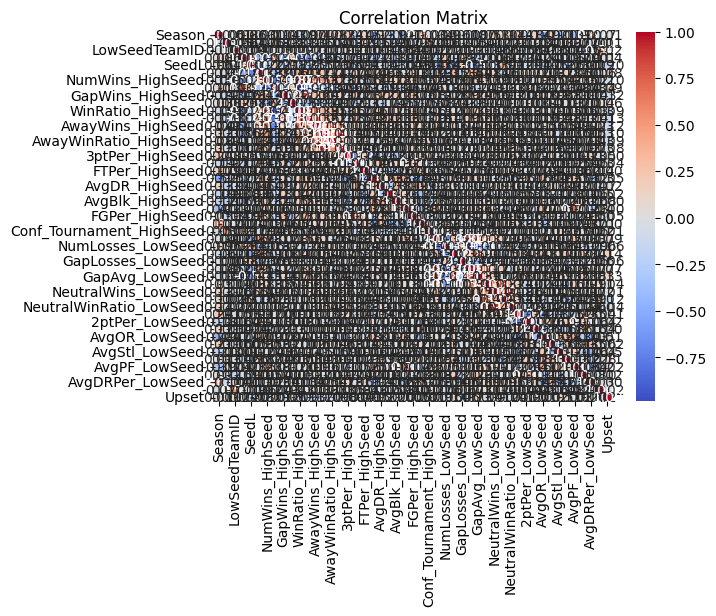

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.rcParams['figure.figsize'] = (30, 30)
#plt.figure(figsize=(120,60))
plt.show()

In [ ]:
correlation_with_target = correlation_matrix['Upset'].sort_values()

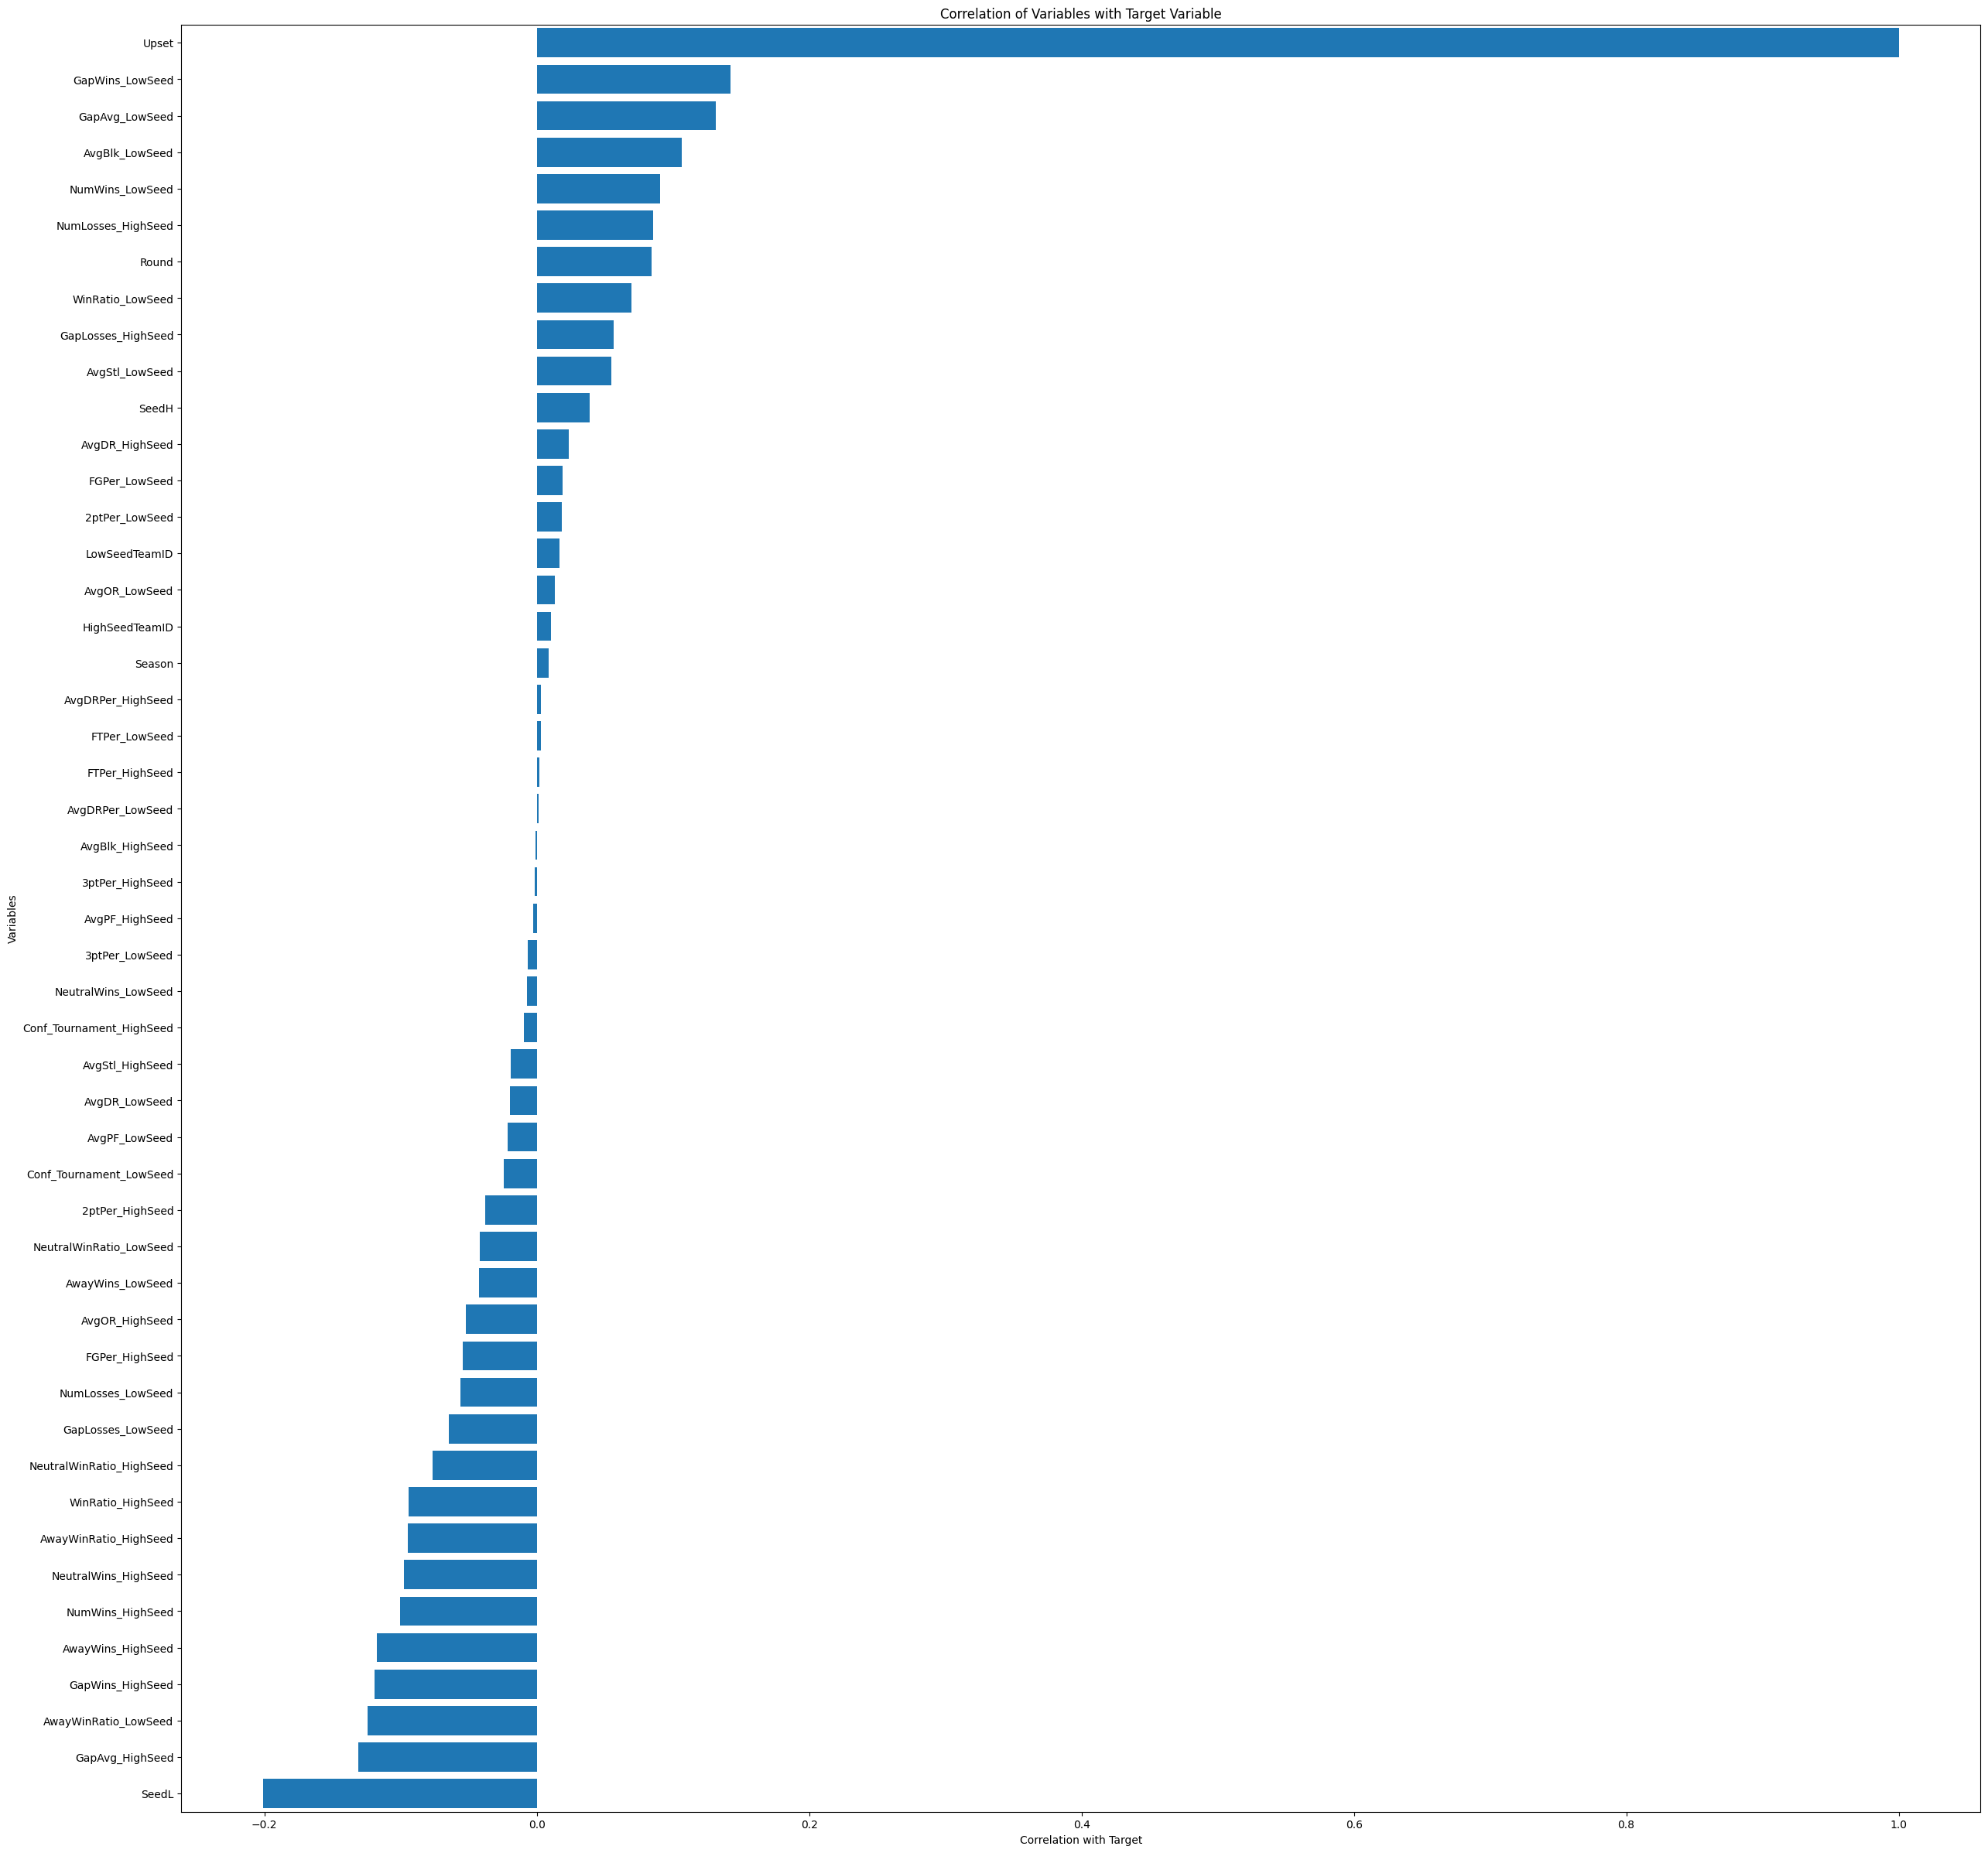

In [ ]:
correlation_with_target.plot(kind='barh')
plt.barh(correlation_with_target.index, correlation_with_target.values)
plt.xlabel('Correlation with Target')
plt.ylabel('Variables')
plt.title('Correlation of Variables with Target Variable')
plt.rcParams['figure.figsize'] = (12, 12)
plt.show()

In [ ]:
#+ GapAvg_LowSeed+ NeutralWinRatio_HighSeed
#formula7 = 'Upset ~ Round*(GapAvg_HighSeed + AwayWinRatio_HighSeed + SeedH) + GapWins_LowSeed + AvgBlk_LowSeed' + GapAvg_LowSeed + GapWins_LowSeed*FTPer_LowSeed
#formula7 = 'Upset ~ Round*(SeedH + SeedL +AwayWinRatio_HighSeed) + GapWins_LowSeed*FTPer_LowSeed + AvgStl_LowSeed + AvgDRPer_LowSeed'
formula7 = 'Upset ~ Round*(SeedH + SeedL) + GapWins_LowSeed*FTPer_LowSeed + AvgStl_LowSeed + AvgDRPer_LowSeed + NumLosses_HighSeed'
lm_upset = smf.ols(formula=formula7, data=df_stats).fit()
print(lm_upset.summary())

                            OLS Regression Results                            
Dep. Variable:                  Upset   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     11.82
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           2.41e-21
Time:                        20:39:53   Log-Likelihood:                -743.53
No. Observations:                1315   AIC:                             1511.
Df Residuals:                    1303   BIC:                             1573.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [ ]:
#old formulas
#AwayWinRatio_HighSeed
#neutralwin ratio * Round = -0.4 / 0.011 p
#awaywin ratio * Round = -0.3 / 0.852 p but 3.0 FTper low seed
#formula6 = 'Upset ~ Round*(SeedL + GapAvg_HighSeed) + AvgStl_LowSeed + AvgBlk_LowSeed + GapWins_LowSeed' #0.10 r2
#formula6 = 'Upset ~ Round*(SeedH + AwayWinRatio_HighSeed) + GapAvg_HighSeed + GapWins_LowSeed'
#formula7 = 'Upset ~ Round*(GapAvg_HighSeed + NeutralWinRatio_HighSeed + GapWins_LowSeed) + AvgBlk_LowSeed + AvgStl_LowSeed'
#formula7 = 'Upset ~ Round*(GapAvg_HighSeed + NeutralWinRatio_HighSeed + GapWins_LowSeed) +  AvgBlk_LowSeed'
#formula8 = 'Upset ~ Round*(GapAvg_HighSeed + GapLosses_HighSeed + NeutralWinRatio_HighSeed) + FTPer_LowSeed +  GapWins_LowSeed*AvgDR_LowSeed + AvgBlk_LowSeed'
#formula9 = 'Upset ~ Round*(GapAvg_HighSeed + GapWins_LowSeed + SeedH) + AvgBlk_LowSeed + AvgStl_LowSeed'

In [ ]:
round1 = df_stats[df_stats['Round']==1]

In [ ]:
X = round1.iloc[:, :-1]  # All columns except the last one
y = round1.iloc[:, -1]   # Last column

In [ ]:
# Add a constant term to the predictors to fit the intercept of the model
X = sm.add_constant(X)

In [ ]:
# Fit the ordinary least squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the summary which includes R-squared values for each predictor
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Upset   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     3.409
Date:                Wed, 20 Mar 2024   Prob (F-statistic):           1.10e-11
Time:                        20:03:44   Log-Likelihood:                -311.69
No. Observations:                 639   AIC:                             713.4
Df Residuals:                     594   BIC:                             914.1
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Season                  

In [ ]:
#check upsets against 23 results
results23 = df_stats[df_stats['Season'] == 2023]

In [ ]:
#predict number of wins
results23['Upset_Pred'] = round(lm_upset.predict(results23))

<ipython-input-70-0688b5dfd2a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results23['Upset_Pred'] = round(lm_upset.predict(results23))


In [ ]:
results23

,Season,HighSeedTeamID,LowSeedTeamID,SeedH,SeedL,Round,NumWins_HighSeed,NumLosses_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,...,AvgOR_LowSeed,AvgDR_LowSeed,AvgStl_LowSeed,AvgBlk_LowSeed,AvgPF_LowSeed,FGPer_LowSeed,AvgDRPer_LowSeed,Conf_Tournament_LowSeed,Upset,Upset_Pred
1248,2023,1338,1280,11,11,0,22.0,11.0,13.909091,10.909091,...,11.613095,22.970238,8.470238,3.333333,15.327381,0.416711,0.716321,0.0,0,0.0
1249,2023,1394,1369,16,16,0,19.0,10.0,14.631579,12.300000,...,7.615809,23.836397,6.680147,3.172794,21.523897,0.433158,0.735162,0.0,0,0.0
1250,2023,1113,1305,11,11,0,22.0,12.0,10.409091,11.666667,...,5.992857,23.900000,6.021429,2.940476,18.523810,0.430975,0.768484,0.0,0,0.0
1251,2023,1192,1411,16,16,0,17.0,15.0,9.411765,10.000000,...,9.608333,23.700000,6.650000,3.150000,18.900000,0.425832,0.736650,1.0,0,-0.0
1252,2023,1104,1394,1,16,1,29.0,5.0,18.241379,12.800000,...,9.913158,22.055263,8.189474,1.465789,19.676316,0.433205,0.723320,1.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,2023,1235,1338,6,11,1,19.0,13.0,16.157895,9.615385,...,8.386364,23.431818,5.227273,3.818182,16.909091,0.449685,0.735719,0.0,1,0.0
1311,2023,1462,1338,3,11,2,25.0,9.0,11.960000,5.444444,...,8.386364,23.431818,5.227273,3.818182,16.909091,0.449685,0.735719,0.0,0,0.0
1312,2023,1388,1433,5,12,1,25.0,7.0,16.200000,7.714286,...,8.476190,22.158730,8.433862,4.722222,16.362434,0.439284,0.726531,1.0,0,0.0
1313,2023,1395,1113,6,11,1,21.0,12.0,15.714286,7.500000,...,9.291667,23.280303,7.412879,4.522727,18.655303,0.405059,0.706077,0.0,0,0.0


In [ ]:
results23['Upset'].count()

67

In [ ]:
upset_count = results23[results23['Upset_Pred']!= results23['Upset']]

In [ ]:
upset_count['Round'].value_counts()

1    7
2    5
3    4
4    3
Name: Round, dtype: int64

## Final Four winner predictor

In [ ]:
round5 = df_stats[df_stats['Round'] == 5]
round6 = df_stats[df_stats['Round'] == 6]
final4 = pd.concat([round5, round6])

In [ ]:
final4

,Season,HighSeedTeamID,LowSeedTeamID,SeedH,SeedL,Round,NumWins_HighSeed,NumLosses_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,...,FTPer_LowSeed,AvgOR_LowSeed,AvgDR_LowSeed,AvgStl_LowSeed,AvgBlk_LowSeed,AvgPF_LowSeed,FGPer_LowSeed,AvgDRPer_LowSeed,Conf_Tournament_LowSeed,Upset
17,2003,1242,1266,2,3,5,23.0,7.0,22.000000,8.142857,...,0.813014,13.143478,23.652174,5.139130,3.547826,20.034783,0.460270,0.656635,0.0,0
22,2003,1400,1393,1,3,5,22.0,6.0,14.818182,6.833333,...,0.660984,16.166667,25.354167,7.712500,7.404167,16.433333,0.432555,0.611802,1.0,1
74,2004,1329,1210,2,3,5,26.0,3.0,17.000000,9.000000,...,0.678364,11.159420,24.949275,8.485507,4.451691,22.234300,0.462335,0.651419,0.0,1
83,2004,1181,1163,1,2,5,27.0,5.0,18.851852,7.200000,...,0.594539,15.768519,27.740741,5.638889,8.185185,17.333333,0.457630,0.669927,0.0,1
144,2005,1228,1257,1,4,5,32.0,1.0,17.875000,1.000000,...,0.763213,11.875000,25.282407,7.439815,3.856481,19.504630,0.439864,0.656297,0.0,0
152,2005,1314,1277,1,5,5,27.0,4.0,22.296296,7.000000,...,0.746312,11.545455,23.325758,6.909091,2.371212,19.969697,0.480720,0.735015,0.0,0
201,2006,1417,1261,2,4,5,27.0,6.0,12.629630,4.833333,...,0.667640,13.812500,25.113636,7.642045,6.022727,16.250000,0.472329,0.692910,0.0,0
208,2006,1196,1206,3,11,5,27.0,6.0,18.703704,4.500000,...,0.677398,10.760870,23.577640,6.599379,3.000000,16.503106,0.459817,0.680777,0.0,0
274,2007,1326,1207,1,2,5,30.0,3.0,16.100000,12.666667,...,0.689369,10.525641,21.365385,5.262821,5.083333,17.012821,0.485570,0.643253,0.0,0
295,2007,1196,1417,1,2,5,29.0,5.0,22.172414,7.800000,...,0.643568,12.320000,20.860000,7.540000,2.860000,17.680000,0.446719,0.683291,0.0,0


In [ ]:
# Specify the column you want to move
column_to_move = 'Upset'

# Create a list of column names with the specified column moved to the last position
new_column_order = [col for col in final4.columns if col != column_to_move] + [column_to_move]

# Reorder the columns in the DataFrame
final4 = final4[new_column_order]

In [ ]:
X = final4.iloc[:, :-1]  # All columns except the last one
y = final4.iloc[:, -1]   # Last column

In [ ]:
# Add a constant term to the predictors to fit the intercept of the model
X = sm.add_constant(X)

In [ ]:
# Fit the ordinary least squares (OLS) model
model = sm.OLS(y, X).fit()

# Print the summary which includes R-squared values for each predictor
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Upset   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.003
Date:                Wed, 20 Mar 2024   Prob (F-statistic):              0.530
Time:                        20:03:44   Log-Likelihood:                 17.288
No. Observations:                  60   AIC:                             59.42
Df Residuals:                      13   BIC:                             157.9
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
formula5 = 'Upset ~ NumWins_HighSeed + AvgDR_HighSeed + AvgPF_HighSeed + Conf_Tournament_HighSeed + AvgBlk_LowSeed + AvgPF_LowSeed + Round*Conf_Tournament_HighSeed'
formulax = 'Upset ~ AvgDR_HighSeed + AvgBlk_LowSeed + Round*FTPer_LowSeed'
lm_final4 = smf.ols(formula=formulax, data=final4).fit()
print(lm_final4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Upset   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     4.661
Date:                Wed, 20 Mar 2024   Prob (F-statistic):            0.00131
Time:                        20:03:44   Log-Likelihood:                -17.404
No. Observations:                  60   AIC:                             46.81
Df Residuals:                      54   BIC:                             59.37
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              16.8766    

In [ ]:
#check upsets against 23 results
results23 = final4[final4['Season'] == 2023]

In [ ]:
#predict number of wins
results23['Upset_Pred'] = round(lm_final4.predict(results23))

<ipython-input-83-a09f1b07ed5f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results23['Upset_Pred'] = round(lm_final4.predict(results23))


In [ ]:
results23['Upset'].count()

3

In [ ]:
results23

,Season,HighSeedTeamID,LowSeedTeamID,SeedH,SeedL,Round,NumWins_HighSeed,NumLosses_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,...,AvgOR_LowSeed,AvgDR_LowSeed,AvgStl_LowSeed,AvgBlk_LowSeed,AvgPF_LowSeed,FGPer_LowSeed,AvgDRPer_LowSeed,Conf_Tournament_LowSeed,Upset,Upset_Pred
1265,2023,1163,1274,4,5,5,25.0,8.0,19.640000,6.000000,...,8.105714,22.322857,7.220000,3.282857,15.237143,0.476843,0.712232,0.0,0,-0.0
1281,2023,1361,1194,5,9,5,26.0,6.0,11.269231,8.666667,...,8.770115,23.793103,5.678161,2.143678,16.063218,0.450326,0.719338,0.0,0,-0.0
1255,2023,1163,1361,4,5,6,25.0,8.0,19.640000,6.000000,...,8.237179,22.435897,7.012821,3.121795,17.717949,0.433842,0.760212,0.0,0,0.0


In [ ]:
results23[results23['Upset_Pred']== results23['Upset']].count()

Season                      3
HighSeedTeamID              3
LowSeedTeamID               3
SeedH                       3
SeedL                       3
Round                       3
NumWins_HighSeed            3
NumLosses_HighSeed          3
GapWins_HighSeed            3
GapLosses_HighSeed          3
WinRatio_HighSeed           3
GapAvg_HighSeed             3
AwayWins_HighSeed           3
NeutralWins_HighSeed        3
AwayWinRatio_HighSeed       3
NeutralWinRatio_HighSeed    3
3ptPer_HighSeed             3
2ptPer_HighSeed             3
FTPer_HighSeed              3
AvgOR_HighSeed              3
AvgDR_HighSeed              3
AvgStl_HighSeed             3
AvgBlk_HighSeed             3
AvgPF_HighSeed              3
FGPer_HighSeed              3
AvgDRPer_HighSeed           3
Conf_Tournament_HighSeed    3
NumWins_LowSeed             3
NumLosses_LowSeed           3
GapWins_LowSeed             3
GapLosses_LowSeed           3
WinRatio_LowSeed            3
GapAvg_LowSeed              3
AwayWins_L

## Actually constructing the algorithm fit!

lm_upset for until the final 4

then a diff algorithm to determine the winner from the final 4

In [ ]:
teams = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/24MarchMadness/MTeams.csv')
teams = teams[['TeamID', 'TeamName']]

In [ ]:
#construct data set from 2024 sample
df_2024 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/24MarchMadness/2024_tourney_seeds.csv')

In [ ]:
df_2024 = df_2024[df_2024['Tournament'] == 'M']

In [ ]:
def extract_first_character(value):
    return value[0]

# Apply the function to create the new column
df_2024['Region'] = df_2024['Seed'].apply(lambda x: extract_first_character(x))

In [ ]:
df_2024['Seed'] = df_2024['Seed'].apply(treat_seed)

In [ ]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tournament  64 non-null     object
 1   Seed        64 non-null     int64 
 2   TeamID      64 non-null     int64 
 3   Region      64 non-null     object
dtypes: int64(2), object(2)
memory usage: 2.5+ KB



```
# Define a list of columns to calculate the differences between the winning and losing teams
cols_to_diff = ['Seed', 'WinRatio', 'GapAvg']

# Iterate over each column in the list and calculate the difference between the winning and losing teams
for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']
```


In [ ]:
def region(region):
  #seperate region
  #region = 'region'
  df = df_2024[df_2024['Region']==region]
  df = df[['Seed','TeamID']]
  df.reset_index(drop=True, inplace=True)
  #split seeds into high & low
  df_highseed = df.loc[0:7]
  df_lowseed = df.loc[8:]
  df_lowseed = df_lowseed.loc[::-1]
  df_lowseed.reset_index(drop=True, inplace=True)
  #reshape dfs
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
  df_lowseed.rename(columns={'Seed': 'SeedL', 'TeamID':'LowSeedTeamID'}, inplace=True)
  #stack dfs back together for round 1 matchup
  df_region = pd.concat([df_highseed, df_lowseed], axis=1)
  return df_region

In [ ]:
df_W = region(region='W')
df_X = region(region='X')
df_Y = region(region='Y')
df_Z = region(region='Z')

<ipython-input-585-470e250ed64d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-585-470e250ed64d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-585-470e250ed64d>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rena

In [ ]:
df_W.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   SeedH           8 non-null      int64
 1   HighSeedTeamID  8 non-null      int64
 2   SeedL           8 non-null      int64
 3   LowSeedTeamID   8 non-null      int64
dtypes: int64(4)
memory usage: 384.0 bytes


```
1 : 16
2 : 15
3 : 14
4 : 13
5 : 12
6 : 11
7 : 10
8 : 9
```



In [ ]:
#stats for 2024
df_szn = df_full[df_full['Season']==2024]
#columns needed
#AwayWinRatio
df_szn = df_szn[['Season', 'TeamID', 'GapAvg', 'GapWins', 'GapLosses', 'NumLosses', 'AvgDRPer','AvgBlk', 'AvgStl', 'AwayWinRatio', 'NumWins', 'NeutralWinRatio', 'Conf_Tournament','FTPer']]

In [ ]:
df_szn

,Season,TeamID,GapAvg,GapWins,GapLosses,NumLosses,AvgDRPer,AvgBlk,AvgStl,AwayWinRatio,NumWins,NeutralWinRatio,Conf_Tournament,FTPer
7255,2024,1101,-2.645161,7.714286,11.176471,17.0,0.711065,2.113445,7.886555,0.500000,14.0,0.142857,0.0,0.740826
7256,2024,1102,-6.193548,12.222222,13.727273,22.0,0.717361,4.315657,6.790404,0.555556,9.0,0.000000,0.0,0.687598
7257,2024,1103,5.551724,11.842105,6.400000,10.0,0.744012,2.718421,5.297368,0.421053,19.0,0.052632,0.0,0.733100
7258,2024,1104,10.451613,21.428571,12.600000,10.0,0.719845,3.733333,6.840476,0.333333,21.0,0.095238,0.0,0.773510
7259,2024,1105,-7.093750,8.636364,15.333333,21.0,0.703839,3.943723,7.740260,0.363636,11.0,0.090909,0.0,0.719066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7612,2024,1474,-5.258065,8.666667,14.052632,19.0,0.726147,2.747807,6.695175,0.250000,12.0,0.083333,1.0,0.715889
7613,2024,1475,-8.034483,8.000000,11.375000,24.0,0.774864,2.300000,5.845833,0.600000,5.0,0.000000,0.0,0.752429
7614,2024,1476,-14.000000,10.666667,16.740741,27.0,0.696637,2.648148,5.407407,0.000000,3.0,0.000000,0.0,0.670147
7615,2024,1477,-9.333333,6.800000,17.400000,20.0,0.692943,4.725000,7.400000,0.500000,10.0,0.100000,1.0,0.703995


In [ ]:
def add_stats(df1, df2):
  #high seed stats
  df_temp = df1.merge(df2, left_on=['HighSeedTeamID'], right_on=['TeamID'])
  df_temp.drop(columns=['TeamID'], inplace=True)
  #low seed stats
  df = df_temp.merge(df2, left_on=['LowSeedTeamID'], right_on=['TeamID'], suffixes=('_HighSeed', '_LowSeed'))
  df.drop(columns=['TeamID', 'Season_HighSeed', 'Season_LowSeed'], inplace=True)
  return df

In [ ]:
df_W = add_stats(df_W, df_szn)
df_X = add_stats(df_X, df_szn)
df_Y = add_stats(df_Y, df_szn)
df_Z = add_stats(df_Z, df_szn)

In [ ]:
df_W

,SeedH,HighSeedTeamID,SeedL,LowSeedTeamID,GapAvg_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,NumLosses_HighSeed,AvgDRPer_HighSeed,AvgBlk_HighSeed,...,GapLosses_LowSeed,NumLosses_LowSeed,AvgDRPer_LowSeed,AvgBlk_LowSeed,AvgStl_LowSeed,AwayWinRatio_LowSeed,NumWins_LowSeed,NeutralWinRatio_LowSeed,Conf_Tournament_LowSeed,FTPer_LowSeed
0,1,1163,16,1391,17.161290,20.357143,12.666667,3.0,0.727990,4.339286,...,16.000000,12.0,0.693493,2.850877,4.828947,0.421053,19.0,0.105263,0.0,0.741724
1,2,1235,15,1355,13.677419,19.875000,7.571429,7.0,0.707253,2.919643,...,8.916667,12.0,0.764509,3.092105,5.901316,0.578947,19.0,0.263158,0.0,0.711235
2,3,1228,14,1287,11.000000,16.913043,6.000000,8.0,0.745103,3.521739,...,14.125000,8.0,0.750666,4.409091,5.431818,0.545455,22.0,0.136364,0.0,0.728393
3,4,1120,13,1463,14.935484,21.625000,8.000000,7.0,0.707254,5.776786,...,7.333333,9.0,0.765343,3.416667,5.861111,0.611111,18.0,0.111111,0.0,0.719783
4,5,1361,12,1412,7.137931,13.200000,6.333333,9.0,0.732113,3.502778,...,10.727273,11.0,0.733181,4.449761,6.205742,0.421053,19.0,0.052632,0.0,0.742370
5,6,1140,11,1182,12.750000,21.173913,8.777778,9.0,0.784999,2.806763,...,9.090909,11.0,0.725257,4.090909,7.343182,0.400000,20.0,0.150000,0.0,0.716382
6,7,1450,10,1179,7.548387,13.565217,9.750000,8.0,0.790859,4.543478,...,12.000000,6.0,0.764824,1.481481,6.305556,0.444444,27.0,0.222222,0.0,0.735902
7,8,1194,9,1321,9.709677,14.000000,5.000000,7.0,0.717586,2.574405,...,8.700000,10.0,0.733785,3.347619,6.873810,0.285714,21.0,0.095238,0.0,0.744306


In [ ]:
df_W.merge(df_szn, left_on=['HighSeedTeamID'], right_on=['TeamID'])

,SeedH,HighSeedTeamID,SeedL,LowSeedTeamID,GapAvg_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,NumLosses_HighSeed,AvgDRPer_HighSeed,AvgBlk_HighSeed,...,GapLosses,NumLosses,AvgDRPer,AvgBlk,AvgStl,AwayWinRatio,NumWins,NeutralWinRatio,Conf_Tournament,FTPer
0,1,1163,16,1391,17.161290,20.357143,12.666667,3.0,0.727990,4.339286,...,12.666667,3.0,0.727990,4.339286,5.392857,0.428571,28.0,0.142857,0.0,0.757395
1,2,1235,15,1355,13.677419,19.875000,7.571429,7.0,0.707253,2.919643,...,7.571429,7.0,0.707253,2.919643,9.360119,0.250000,24.0,0.041667,0.0,0.675282
2,3,1228,14,1287,11.000000,16.913043,6.000000,8.0,0.745103,3.521739,...,6.000000,8.0,0.745103,3.521739,4.608696,0.347826,23.0,0.086957,0.0,0.758324
3,4,1120,13,1463,14.935484,21.625000,8.000000,7.0,0.707254,5.776786,...,8.000000,7.0,0.707254,5.776786,7.110119,0.375000,24.0,0.166667,0.0,0.730920
4,5,1361,12,1412,7.137931,13.200000,6.333333,9.0,0.732113,3.502778,...,6.333333,9.0,0.732113,3.502778,7.397222,0.400000,20.0,0.150000,0.0,0.737241
5,6,1140,11,1182,12.750000,21.173913,8.777778,9.0,0.784999,2.806763,...,8.777778,9.0,0.784999,2.806763,6.033816,0.304348,23.0,0.173913,0.0,0.703718
6,7,1450,10,1179,7.548387,13.565217,9.750000,8.0,0.790859,4.543478,...,9.750000,8.0,0.790859,4.543478,4.703804,0.347826,23.0,0.086957,0.0,0.697229
7,8,1194,9,1321,9.709677,14.000000,5.000000,7.0,0.717586,2.574405,...,5.000000,7.0,0.717586,2.574405,6.690476,0.458333,24.0,0.250000,0.0,0.731079


In [ ]:
def winners(df):
    selected_columns = []
    for index, row in df.iterrows():
        if row['Upset_Pred'] == 0:
            selected_columns.append([row['SeedH'].astype(int), row['HighSeedTeamID'].astype(int)])
        else:
            selected_columns.append([row['SeedL'].astype(int), row['LowSeedTeamID'].astype(int)])
    return pd.DataFrame(selected_columns, columns=['Seed', 'TeamID'])

In [ ]:
teams

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M
...,...,...
373,1474,Queens NC
374,1475,Southern Indiana
375,1476,Stonehill
376,1477,TX A&M Commerce


In [ ]:
#predict rounds 1-4

Round of 64 (Round 1)

In [ ]:
#W (East)
df_W['Round'] = 1
df_W['Upset_Pred'] = round(lm_upset.predict(df_W))

In [ ]:
df_W

,SeedH,HighSeedTeamID,SeedL,LowSeedTeamID,GapAvg_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,NumLosses_HighSeed,AvgDRPer_HighSeed,AvgBlk_HighSeed,...,AvgDRPer_LowSeed,AvgBlk_LowSeed,AvgStl_LowSeed,AwayWinRatio_LowSeed,NumWins_LowSeed,NeutralWinRatio_LowSeed,Conf_Tournament_LowSeed,FTPer_LowSeed,Round,Upset_Pred
0,1,1163,16,1391,17.161290,20.357143,12.666667,3.0,0.727990,4.339286,...,0.693493,2.850877,4.828947,0.421053,19.0,0.105263,0.0,0.741724,1,-0.0
1,2,1235,15,1355,13.677419,19.875000,7.571429,7.0,0.707253,2.919643,...,0.764509,3.092105,5.901316,0.578947,19.0,0.263158,0.0,0.711235,1,0.0
2,3,1228,14,1287,11.000000,16.913043,6.000000,8.0,0.745103,3.521739,...,0.750666,4.409091,5.431818,0.545455,22.0,0.136364,0.0,0.728393,1,0.0
3,4,1120,13,1463,14.935484,21.625000,8.000000,7.0,0.707254,5.776786,...,0.765343,3.416667,5.861111,0.611111,18.0,0.111111,0.0,0.719783,1,0.0
4,5,1361,12,1412,7.137931,13.200000,6.333333,9.0,0.732113,3.502778,...,0.733181,4.449761,6.205742,0.421053,19.0,0.052632,0.0,0.742370,1,0.0
5,6,1140,11,1182,12.750000,21.173913,8.777778,9.0,0.784999,2.806763,...,0.725257,4.090909,7.343182,0.400000,20.0,0.150000,0.0,0.716382,1,0.0
6,7,1450,10,1179,7.548387,13.565217,9.750000,8.0,0.790859,4.543478,...,0.764824,1.481481,6.305556,0.444444,27.0,0.222222,0.0,0.735902,1,0.0
7,8,1194,9,1321,9.709677,14.000000,5.000000,7.0,0.717586,2.574405,...,0.733785,3.347619,6.873810,0.285714,21.0,0.095238,0.0,0.744306,1,0.0


In [ ]:
#X (South)
df_X['Round'] = 1
df_X['Upset_Pred'] = round(lm_upset.predict(df_X))


In [ ]:
#Y (West)
df_Y['Round'] = 1
df_Y['Upset_Pred'] = round(lm_upset.predict(df_Y))

In [ ]:
#Z (Midwest)
df_Z['Round'] = 1
df_Z['Upset_Pred'] = round(lm_upset.predict(df_Z))

In [ ]:
df_Z['Upset_Pred_test'] = round(lm_upset.predict(df_Z),2)

In [ ]:
df_Z

,SeedH,HighSeedTeamID,SeedL,LowSeedTeamID,GapAvg_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,NumLosses_HighSeed,AvgDRPer_HighSeed,AvgBlk_HighSeed,...,AvgBlk_LowSeed,AvgStl_LowSeed,AwayWinRatio_LowSeed,NumWins_LowSeed,NeutralWinRatio_LowSeed,Conf_Tournament_LowSeed,FTPer_LowSeed,Round,Upset_Pred,Upset_Pred_test
0,1,1222,16,1255,17.290323,19.785714,6.000000,3.0,0.726090,4.541667,...,2.365385,6.762821,0.444444,18.0,0.111111,0.0,0.671419,1,0.0,0.04
1,2,1266,15,1443,9.387097,16.478261,11.000000,8.0,0.691097,3.157609,...,2.926136,7.261364,0.437500,16.0,0.062500,0.0,0.704368,1,0.0,0.15
2,3,1246,14,1324,10.387097,16.304348,6.625000,8.0,0.713508,6.475543,...,2.703557,6.592885,0.565217,23.0,0.173913,0.0,0.756355,1,0.0,0.21
3,4,1181,13,1436,12.967742,18.250000,5.142857,7.0,0.762348,3.660714,...,3.200000,4.770000,0.480000,25.0,0.080000,1.0,0.667559,1,0.0,0.16
4,5,1458,12,1241,4.645161,13.578947,9.500000,12.0,0.779555,1.592105,...,2.633333,9.333333,0.533333,30.0,0.133333,0.0,0.721424,1,0.0,0.41
5,6,1403,11,1301,6.935484,14.181818,10.777778,9.0,0.683534,2.553030,...,3.283835,7.272556,0.368421,19.0,0.157895,0.0,0.718841,1,0.0,0.35
6,7,1196,10,1129,7.290323,14.095238,7.000000,10.0,0.730810,5.292857,...,2.261111,5.452778,0.450000,20.0,0.100000,0.0,0.736848,1,0.0,0.39
7,8,1304,9,1401,7.451613,16.181818,13.888889,9.0,0.703561,2.618687,...,2.820513,7.079060,0.444444,18.0,0.111111,0.0,0.707963,1,0.0,0.43


In [ ]:
df_Wwin = winners(df_W)
df_Xwin = winners(df_X)
df_Ywin = winners(df_Y)
df_Zwin = winners(df_Z)

In [ ]:
def display_winners(round, df1, df2, df3, df4):
  df1 = df1.merge(teams, on='TeamID')
  df2 = df2.merge(teams, on='TeamID')
  df3 = df3.merge(teams, on='TeamID')
  df4 = df4.merge(teams, on='TeamID')
  #return print(f"{round}:")
  return print(f"{round}:", display(df1, df2, df3, df4))

In [ ]:
display_winners(round='Round of 64', df1=df_Wwin, df2=df_Xwin, df3=df_Ywin, df4=df_Zwin)

,Seed,TeamID,TeamName
0,1,1163,Connecticut
1,2,1235,Iowa St
2,3,1228,Illinois
3,4,1120,Auburn
4,5,1361,San Diego St
5,6,1140,BYU
6,7,1450,Washington St
7,8,1194,FL Atlantic


,Seed,TeamID,TeamName
0,1,1314,North Carolina
1,2,1112,Arizona
2,3,1124,Baylor
3,4,1104,Alabama
4,5,1388,St Mary's CA
5,6,1155,Clemson
6,7,1173,Dayton
7,8,1280,Mississippi St


,Seed,TeamID,TeamName
0,1,1345,Purdue
1,2,1397,Tennessee
2,3,1166,Creighton
3,4,1242,Kansas
4,5,1211,Gonzaga
5,6,1376,South Carolina
6,7,1400,Texas
7,8,1429,Utah St


,Seed,TeamID,TeamName
0,1,1222,Houston
1,2,1266,Marquette
2,3,1246,Kentucky
3,4,1181,Duke
4,5,1458,Wisconsin
5,6,1403,Texas Tech
6,7,1196,Florida
7,8,1304,Nebraska


Round of 64: None


Round 2

In [ ]:
def round32(df):
  df.reset_index(drop=True, inplace=True)
  #split seeds into high & low
  df_highseed = df.loc[0:3]
  df_lowseed = df.loc[4:]
  df_lowseed = df_lowseed.loc[::-1]
  df_lowseed.reset_index(drop=True, inplace=True)
  #reshape dfs
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
  df_lowseed.rename(columns={'Seed': 'SeedL', 'TeamID':'LowSeedTeamID'}, inplace=True)
  #stack dfs back together for round 1 matchup
  df = pd.concat([df_highseed, df_lowseed], axis=1)
  #switch IDs if the high seed lost
  df['HighSeedTeamID'], df['LowSeedTeamID'] = df['LowSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['HighSeedTeamID']), df['HighSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['LowSeedTeamID'])
  df['SeedH'], df['SeedL'] = df['SeedL'].where(df['SeedH'] > df['SeedL'], df['SeedH']), df['SeedH'].where(df['SeedH'] > df['SeedL'], df['SeedL'])
  return df

In [ ]:
df_W2 = add_stats(round32(df_Wwin), df_szn)
df_X2 = add_stats(round32(df_Xwin), df_szn)
df_Y2 = add_stats(round32(df_Ywin), df_szn)
df_Z2 = add_stats(round32(df_Zwin), df_szn)

<ipython-input-607-63cb09c5e3a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-607-63cb09c5e3a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-607-63cb09c5e3a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(

In [ ]:
#W2 (East)
df_W2['Round'] = 2
df_W2['Upset_Pred'] = round(lm_upset.predict(df_W2))

In [ ]:
#X2 (South)
df_X2['Round'] = 2
df_X2['Upset_Pred'] = round(lm_upset.predict(df_X2))


In [ ]:
#Y2 (West)
df_Y2['Round'] = 2
df_Y2['Upset_Pred'] = round(lm_upset.predict(df_Y2))

In [ ]:
#Z2 (Midwest)
df_Z2['Round'] = 2
df_Z2['Upset_Pred'] = round(lm_upset.predict(df_Z2))

In [ ]:
df_W2win = winners(df_W2)
df_X2win = winners(df_X2)
df_Y2win = winners(df_Y2)
df_Z2win = winners(df_Z2)

In [ ]:
display_winners(round='Round of 32', df1=df_W2win, df2=df_X2win, df3=df_Y2win, df4=df_Z2win)

,Seed,TeamID,TeamName
0,1,1163,Connecticut
1,2,1235,Iowa St
2,6,1140,BYU
3,5,1361,San Diego St


,Seed,TeamID,TeamName
0,1,1314,North Carolina
1,2,1112,Arizona
2,3,1124,Baylor
3,5,1388,St Mary's CA


,Seed,TeamID,TeamName
0,1,1345,Purdue
1,2,1397,Tennessee
2,3,1166,Creighton
3,5,1211,Gonzaga


,Seed,TeamID,TeamName
0,1,1222,Houston
1,2,1266,Marquette
2,3,1246,Kentucky
3,4,1181,Duke


Round of 32: None


Sweet 16
(Round 3)

In [ ]:
def sweet16(df):
  df.reset_index(drop=True, inplace=True)
  #split seeds into high & low
  df_highseed = df.loc[0:1]
  df_lowseed = df.loc[2:]
  df_lowseed = df_lowseed.loc[::-1]
  df_lowseed.reset_index(drop=True, inplace=True)
  #reshape dfs
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
  df_lowseed.rename(columns={'Seed': 'SeedL', 'TeamID':'LowSeedTeamID'}, inplace=True)
  #stack dfs back together for round 1 matchup
  df = pd.concat([df_highseed, df_lowseed], axis=1)
  #switch IDs if the high seed lost
  df['HighSeedTeamID'], df['LowSeedTeamID'] = df['LowSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['HighSeedTeamID']), df['HighSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['LowSeedTeamID'])
  df['SeedH'], df['SeedL'] = df['SeedL'].where(df['SeedH'] > df['SeedL'], df['SeedH']), df['SeedH'].where(df['SeedH'] > df['SeedL'], df['SeedL'])
  return df

In [ ]:
df_W3 = add_stats(sweet16(df_W2win), df_szn)
df_X3 = add_stats(sweet16(df_X2win), df_szn)
df_Y3 = add_stats(sweet16(df_Y2win), df_szn)
df_Z3 = add_stats(sweet16(df_Z2win), df_szn)

<ipython-input-615-9dbe1b9754bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-615-9dbe1b9754bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-615-9dbe1b9754bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(

In [ ]:
#W3 (East)
df_W3['Round'] = 3
df_W3['Upset_Pred'] = round(lm_upset.predict(df_W3))

In [ ]:
#X3 (South)
df_X3['Round'] = 3
df_X3['Upset_Pred'] = round(lm_upset.predict(df_X3))


In [ ]:
#Y3 (West)
df_Y3['Round'] = 3
df_Y3['Upset_Pred'] = round(lm_upset.predict(df_Y3))

In [ ]:
#Z3 (Midwest)
df_Z3['Round'] = 3
df_Z3['Upset_Pred'] = round(lm_upset.predict(df_Z3))

In [ ]:
df_W3win = winners(df_W3)
df_X3win = winners(df_X3)
df_Y3win = winners(df_Y3)
df_Z3win = winners(df_Z3)

In [ ]:
display_winners(round='Sweet 16', df1=df_W3win, df2=df_X3win, df3=df_Y3win, df4=df_Z3win)

,Seed,TeamID,TeamName
0,1,1163,Connecticut
1,2,1235,Iowa St


,Seed,TeamID,TeamName
0,1,1314,North Carolina
1,2,1112,Arizona


,Seed,TeamID,TeamName
0,1,1345,Purdue
1,2,1397,Tennessee


,Seed,TeamID,TeamName
0,1,1222,Houston
1,2,1266,Marquette


Sweet 16: None


Round 4 (Elite 8)

In [ ]:
def elite8(df):
  df_highseed = pd.DataFrame(df.loc[0]).T
  df_lowseed = pd.DataFrame(df.loc[1]).T
  #reshape dfs
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
  df_lowseed.rename(columns={'Seed': 'SeedL', 'TeamID':'LowSeedTeamID'}, inplace=True)
  df_lowseed.reset_index(inplace=True)
  #stack dfs back together for matchup
  df = pd.concat([df_highseed, df_lowseed], axis=1)
  df.drop(columns=['index'], inplace=True)
  #switch IDs if the high seed lost
  df['HighSeedTeamID'], df['LowSeedTeamID'] = df['LowSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['HighSeedTeamID']), df['HighSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['LowSeedTeamID'])
  df['SeedH'], df['SeedL'] = df['SeedL'].where(df['SeedH'] > df['SeedL'], df['SeedH']), df['SeedH'].where(df['SeedH'] > df['SeedL'], df['SeedL'])
  return df

In [ ]:
df_W4 = add_stats(elite8(df_W3win), df_szn)
df_X4 = add_stats(elite8(df_X3win), df_szn)
df_Y4 = add_stats(elite8(df_Y3win), df_szn)
df_Z4 = add_stats(elite8(df_Z3win), df_szn)

In [ ]:
#W4 (East)
df_W4['Round'] = 4
df_W4['Upset_Pred'] = round(lm_upset.predict(df_W4))

In [ ]:
#X4 (South)
df_X4['Round'] = 4
df_X4['Upset_Pred'] = round(lm_upset.predict(df_X4))


In [ ]:
#Y4 (West)
df_Y4['Round'] = 4
df_Y4['Upset_Pred'] = round(lm_upset.predict(df_Y4))

In [ ]:
#Z4 (Midwest)
df_Z4['Round'] = 4
df_Z4['Upset_Pred'] = round(lm_upset.predict(df_Z4))

In [ ]:
df_W4win = winners(df_W4)
df_X4win = winners(df_X4)
df_Y4win = winners(df_Y4)
df_Z4win = winners(df_Z4)

In [ ]:
display_winners(round='Elite8', df1=df_W4win, df2=df_X4win, df3=df_Y4win, df4=df_Z4win)

,Seed,TeamID,TeamName
0,1,1163,Connecticut


,Seed,TeamID,TeamName
0,1,1314,North Carolina


,Seed,TeamID,TeamName
0,1,1345,Purdue


,Seed,TeamID,TeamName
0,1,1222,Houston


Elite8: None


In [ ]:
#different algorithm for round 5 & 6 = lm_final4
#but i decided not to do that
#because it does nothing

Final 4 (Round 5)

In [ ]:
def final4(df1, df2):
  df_highseed = df1
  df_lowseed = df2
  #reshape dfs
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
  df_lowseed.rename(columns={'Seed': 'SeedL', 'TeamID':'LowSeedTeamID'}, inplace=True)
  df_lowseed.reset_index(inplace=True)
  #stack dfs back together for matchup
  df = pd.concat([df_highseed, df_lowseed], axis=1)
  df.drop(columns=['index'], inplace=True)
  #switch IDs if the high seed lost
  df['HighSeedTeamID'], df['LowSeedTeamID'] = df['LowSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['HighSeedTeamID']), df['HighSeedTeamID'].where(df['SeedH'] > df['SeedL'], df['LowSeedTeamID'])
  df['SeedH'], df['SeedL'] = df['SeedL'].where(df['SeedH'] > df['SeedL'], df['SeedH']), df['SeedH'].where(df['SeedH'] > df['SeedL'], df['SeedL'])
  return df

In [ ]:
df_WX = add_stats(final4(df1=df_W4win, df2=df_X4win), df_szn)
df_YZ = add_stats(final4(df1=df_Y4win, df2=df_Z4win), df_szn)

In [ ]:
#WX (East vs West)
df_WX['Round'] = 5
df_WX['Upset_Pred'] = round(lm_upset.predict(df_WX))


In [ ]:
#YZ (South vs Midwest)
df_YZ['Round'] = 5
df_YZ['Upset_Pred'] = round(lm_upset.predict(df_YZ))

In [ ]:
df_WXwin = winners(df_WX)
df_YZwin = winners(df_YZ)

In [ ]:
winners(df_WX).merge(teams, on='TeamID')

,Seed,TeamID,TeamName
0,1,1163,Connecticut


In [ ]:
winners(df_YZ).merge(teams, on='TeamID')

,Seed,TeamID,TeamName
0,1,1345,Purdue


Final (Round 6)

In [ ]:
df_final = add_stats(final4(df1=df_WXwin, df2=df_YZwin), df_szn)

In [ ]:
df_final['Round'] = 6
df_final['Upset_Pred'] = round(lm_upset.predict(df_final))

In [ ]:
df_final

,SeedH,HighSeedTeamID,SeedL,LowSeedTeamID,GapAvg_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,NumLosses_HighSeed,AvgDRPer_HighSeed,AvgBlk_HighSeed,...,AvgDRPer_LowSeed,AvgBlk_LowSeed,AvgStl_LowSeed,AwayWinRatio_LowSeed,NumWins_LowSeed,NeutralWinRatio_LowSeed,Conf_Tournament_LowSeed,FTPer_LowSeed,Round,Upset_Pred
0,1,1163,1,1345,17.16129,20.357143,12.666667,3.0,0.72799,4.339286,...,0.796676,3.72619,3.904762,0.428571,28.0,0.178571,0.0,0.774565,6,0.0


In [ ]:
winners(df_final).merge(teams, on='TeamID')

,Seed,TeamID,TeamName
0,1,1163,Connecticut


## Upset set at 40%

In [ ]:
def upset_wt(df):
    selected_columns = []
    for index, row in df.iterrows():
        if row['Upset_Pred'] < 0.40:
            selected_columns.append([row['SeedH'].astype(int), row['HighSeedTeamID'].astype(int)])
        else:
            selected_columns.append([row['SeedL'].astype(int), row['LowSeedTeamID'].astype(int)])
    return pd.DataFrame(selected_columns, columns=['Seed', 'TeamID'])

In [ ]:
#W (East)
df_W['Round'] = 1
df_W['Upset_Pred'] = round(lm_upset.predict(df_W), 2)

In [ ]:
#X (South)
df_X['Round'] = 1
df_X['Upset_Pred'] = round(lm_upset.predict(df_X), 2)


In [ ]:
#Y (West)
df_Y['Round'] = 1
df_Y['Upset_Pred'] = round(lm_upset.predict(df_Y), 2)

In [ ]:
#Z (Midwest)
df_Z['Round'] = 1
df_Z['Upset_Pred'] = round(lm_upset.predict(df_Z), 2)

In [ ]:
df_Wup = upset_wt(df_W)
df_Xup = upset_wt(df_X)
df_Yup = upset_wt(df_Y)
df_Zup = upset_wt(df_Z)

In [ ]:
display_winners(round='Round of 64', df1=df_Wup, df2=df_Xup, df3=df_Yup, df4=df_Zup)

,Seed,TeamID,TeamName
0,1,1163,Connecticut
1,2,1235,Iowa St
2,3,1228,Illinois
3,4,1120,Auburn
4,5,1361,San Diego St
5,6,1140,BYU
6,7,1450,Washington St
7,8,1194,FL Atlantic


,Seed,TeamID,TeamName
0,1,1314,North Carolina
1,2,1112,Arizona
2,3,1124,Baylor
3,4,1104,Alabama
4,5,1388,St Mary's CA
5,11,1307,New Mexico
6,7,1173,Dayton
7,9,1277,Michigan St


,Seed,TeamID,TeamName
0,1,1345,Purdue
1,2,1397,Tennessee
2,3,1166,Creighton
3,4,1242,Kansas
4,5,1211,Gonzaga
5,6,1376,South Carolina
6,10,1161,Colorado St
7,9,1395,TCU


,Seed,TeamID,TeamName
0,1,1222,Houston
1,2,1266,Marquette
2,3,1246,Kentucky
3,4,1181,Duke
4,12,1241,James Madison
5,6,1403,Texas Tech
6,7,1196,Florida
7,9,1401,Texas A&M


Round of 64: None


In [ ]:
df_W2 = add_stats(round32(df_Wup), df_szn)
df_X2 = add_stats(round32(df_Xup), df_szn)
df_Y2 = add_stats(round32(df_Yup), df_szn)
df_Z2 = add_stats(round32(df_Zup), df_szn)

<ipython-input-607-63cb09c5e3a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-607-63cb09c5e3a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-607-63cb09c5e3a4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(

In [ ]:
#W2 (East)
df_W2['Round'] = 2
df_W2['Upset_Pred'] = round(lm_upset.predict(df_W2), 2)

In [ ]:
#X2 (South)
df_X2['Round'] = 2
df_X2['Upset_Pred'] = round(lm_upset.predict(df_X2), 2)


In [ ]:
#Y2 (West)
df_Y2['Round'] = 2
df_Y2['Upset_Pred'] = round(lm_upset.predict(df_Y2), 2)

In [ ]:
#Z2 (Midwest)
df_Z2['Round'] = 2
df_Z2['Upset_Pred'] = round(lm_upset.predict(df_Z2), 2)

In [ ]:
df_W2up = upset_wt(df_W2)
df_X2up = upset_wt(df_X2)
df_Y2up = upset_wt(df_Y2)
df_Z2up = upset_wt(df_Z2)

In [ ]:
display_winners(round='Round of 32', df1=df_W2up, df2=df_X2up, df3=df_Y2up, df4=df_Z2up)

,Seed,TeamID,TeamName
0,1,1163,Connecticut
1,2,1235,Iowa St
2,6,1140,BYU
3,5,1361,San Diego St


,Seed,TeamID,TeamName
0,1,1314,North Carolina
1,2,1112,Arizona
2,3,1124,Baylor
3,5,1388,St Mary's CA


,Seed,TeamID,TeamName
0,1,1345,Purdue
1,2,1397,Tennessee
2,6,1376,South Carolina
3,5,1211,Gonzaga


,Seed,TeamID,TeamName
0,1,1222,Houston
1,7,1196,Florida
2,6,1403,Texas Tech
3,4,1181,Duke


Round of 32: None


In [ ]:
df_W3 = add_stats(sweet16(df_W2up), df_szn)
df_X3 = add_stats(sweet16(df_X2up), df_szn)
df_Y3 = add_stats(sweet16(df_Y2up), df_szn)
df_Z3 = add_stats(sweet16(df_Z2up), df_szn)

<ipython-input-615-9dbe1b9754bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-615-9dbe1b9754bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(columns={'Seed': 'SeedH', 'TeamID':'HighSeedTeamID'}, inplace=True)
<ipython-input-615-9dbe1b9754bc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_highseed.rename(

In [ ]:
#W3 (East)
df_W3['Round'] = 3
df_W3['Upset_Pred'] = round(lm_upset.predict(df_W3), 2)

In [ ]:
#X3 (South)
df_X3['Round'] = 3
df_X3['Upset_Pred'] = round(lm_upset.predict(df_X3), 2)


In [ ]:
#Y3 (West)
df_Y3['Round'] = 3
df_Y3['Upset_Pred'] = round(lm_upset.predict(df_Y3), 2)

In [ ]:
#Z3 (Midwest)
df_Z3['Round'] = 3
df_Z3['Upset_Pred'] = round(lm_upset.predict(df_Z3), 2)

In [ ]:
df_W3up = upset_wt(df_W3)
df_X3up = upset_wt(df_X3)
df_Y3up = upset_wt(df_Y3)
df_Z3up = upset_wt(df_Z3)

In [ ]:
display_winners(round='Sweet 16', df1=df_W3up, df2=df_X3up, df3=df_Y3up, df4=df_Z3up)

,Seed,TeamID,TeamName
0,1,1163,Connecticut
1,6,1140,BYU


,Seed,TeamID,TeamName
0,5,1388,St Mary's CA
1,3,1124,Baylor


,Seed,TeamID,TeamName
0,1,1345,Purdue
1,2,1397,Tennessee


,Seed,TeamID,TeamName
0,1,1222,Houston
1,7,1196,Florida


Sweet 16: None


In [ ]:
df_W4 = add_stats(elite8(df_W3up), df_szn)
df_X4 = add_stats(elite8(df_X3up), df_szn)
df_Y4 = add_stats(elite8(df_Y3up), df_szn)
df_Z4 = add_stats(elite8(df_Z3up), df_szn)

In [ ]:
#W4 (East)
df_W4['Round'] = 4
df_W4['Upset_Pred'] = round(lm_upset.predict(df_W4), 2)

In [ ]:
#X4 (South)
df_X4['Round'] = 4
df_X4['Upset_Pred'] = round(lm_upset.predict(df_X4), 2)


In [ ]:
#Y4 (West)
df_Y4['Round'] = 4
df_Y4['Upset_Pred'] = round(lm_upset.predict(df_Y4), 2)

In [ ]:
#Z4 (Midwest)
df_Z4['Round'] = 4
df_Z4['Upset_Pred'] = round(lm_upset.predict(df_Z4), 2)

In [ ]:
df_W4up = upset_wt(df_W4)
df_X4up = upset_wt(df_X4)
df_Y4up = upset_wt(df_Y4)
df_Z4up = upset_wt(df_Z4)

In [ ]:
display_winners(round='Elite8', df1=df_W4up, df2=df_X4up, df3=df_Y4up, df4=df_Z4up)

,Seed,TeamID,TeamName
0,1,1163,Connecticut


,Seed,TeamID,TeamName
0,5,1388,St Mary's CA


,Seed,TeamID,TeamName
0,1,1345,Purdue


,Seed,TeamID,TeamName
0,1,1222,Houston


Elite8: None


In [ ]:
df_WX = add_stats(final4(df1=df_W4up, df2=df_X4up), df_szn)
df_YZ = add_stats(final4(df1=df_Y4up, df2=df_Z4up), df_szn)

In [ ]:
#WX (East vs West)
df_WX['Round'] = 5
df_WX['Upset_Pred'] = round(lm_upset.predict(df_WX), 2)


In [ ]:
#YZ (South vs Midwest)
df_YZ['Round'] = 5
df_YZ['Upset_Pred'] = round(lm_upset.predict(df_YZ), 2)

In [ ]:
df_WXup = upset_wt(df_WX)
df_YZup = upset_wt(df_YZ)

In [ ]:
upset_wt(df_WX).merge(teams, on='TeamID')

,Seed,TeamID,TeamName
0,1,1163,Connecticut


In [ ]:
upset_wt(df_YZ).merge(teams, on='TeamID')

,Seed,TeamID,TeamName
0,1,1345,Purdue


In [ ]:
df_final = add_stats(final4(df1=df_WXup, df2=df_YZup), df_szn)

In [ ]:
df_final['Round'] = 6
df_final['Upset_Pred'] = round(lm_upset.predict(df_final), 2)

In [ ]:
df_final

,SeedH,HighSeedTeamID,SeedL,LowSeedTeamID,GapAvg_HighSeed,GapWins_HighSeed,GapLosses_HighSeed,NumLosses_HighSeed,AvgDRPer_HighSeed,AvgBlk_HighSeed,...,AvgDRPer_LowSeed,AvgBlk_LowSeed,AvgStl_LowSeed,AwayWinRatio_LowSeed,NumWins_LowSeed,NeutralWinRatio_LowSeed,Conf_Tournament_LowSeed,FTPer_LowSeed,Round,Upset_Pred
0,1,1163,1,1345,17.16129,20.357143,12.666667,3.0,0.72799,4.339286,...,0.796676,3.72619,3.904762,0.428571,28.0,0.178571,0.0,0.774565,6,0.1


In [ ]:
upset_wt(df_final).merge(teams, on='TeamID')

,Seed,TeamID,TeamName
0,1,1163,Connecticut
